# 0. Import Libraries

In [1]:
import ROOT as root

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# from scipy.ndimage import convolve
# from scipy import stats

import time
import copy

import os.path

Welcome to JupyROOT 6.26/04


---
# 1. Load QC/TDC from Text File

## 1.0. Description

Takes a formatted text file of calorimeter data and returns 3 data products:
- `QDC`/`TDC`: An n x 8 x 8 array for QDC and TDC values, formatted `QDC[event_index][x_coord][y_coord]`
- `ogEventNums`: An array where `ogEventNums[event_index]` contains the original event number in the uncut run
    - This accomodates input files that already have some PID cuts applied causing event numbers to have gaps, such as filtering only for electron events

## 1.1. Helper Function

In [2]:
def load_TQDC(finPath):
    basePath = "/media/sf_data/"

    # load data from file
    fin = os.path.join(basePath, finPath)
    t0 = time.time()
    raw_data = np.loadtxt(fin, skiprows = 5)
    t1 = time.time()
    print(f"Data file read in {t1-t0:.2f} seconds.")
    # return raw_data

    
    # initialize formatted data array
    num_events = raw_data.shape[0]
    print(f'There are {num_events} events')
    TDC = np.zeros((num_events, 8, 8), dtype=float)
    QDC = np.zeros((num_events, 8, 8), dtype=float)
    ogEventNums = np.zeros((num_events), dtype=int)
    
    
    # format data to [event#][x][y]
    t0 = time.time()
    i_event = -1

    
    for event in raw_data:
        i_event += 1 
        for x in range(8):
            # # this method preserves the original event number, but doesn't work when events aren't one by one
            # TDC [ np.int_(event[0]) ] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            # QDC [ np.int_(event[0]) ] [x] [:] = event[16*x+2 : 16*x+17 : 2]
            
            TDC [i_event] [x] [:] = event[16*x+1 : 16*x+17 : 2]
            QDC [i_event] [x] [:] = event[16*x+2 : 16*x+17 : 2] 
            ogEventNums [i_event] = event[0]
            
    t1 = time.time()
    print(f"Data file formatted to array in {t1-t0:.2f} seconds.")
    
    return TDC, QDC, ogEventNums

## 1.2. Usage

In [53]:
# finPath = "calorimeter/elog_2341/run12130_calo_qdc_tdc_raw.txt" # First 100,000 (out of 1 mil) events, completely raw and unfiltered 
finPath = "calorimeter/elog_2341/run12130_calo_qdc_tdc_cut.txt" # BH electron PID cut + beam monitor hit cut

raw_data = load_TQDC(finPath)

Data file read in 33.68 seconds.
There are 674056 events
Data file formatted to array in 8.65 seconds.


---

# 2. 8x8 of Individual QDC/TDC Hits

## 2.x. Depracated Code

In [ ]:
##################################################################################
# Individual plots (upgraded to composite graph on 6/27/22



# def plotEvent_QDC(data, event, ogEventNums):
#     '''
#     Makes a 2D histogram of QDC values observed by calorimeter
#     '''
    
#     ### Set flexible* max value for colorbar (*if the max qdc of this event is greater than the preset value, then use the actual max qdc value)
#         # To cancel this effect, just set `presetMaxQDC` to 0. I usually set it to ~600.
#     presetMaxQDC = 600
    
#     if np.amax(data[event]) > presetMaxQDC:
#         this_vmax = np.amax(data[event])
#     else:
#         this_vmax = presetMaxQDC

#     ### Configure and show plot
#     fig = plt.figure(figsize=(7,5))
#     plt.imshow(data[event], cmap=colormap, vmin=0, vmax=this_vmax)
#     plt.gca().invert_yaxis()

#     plt.title(f'QDC for Event #{ogEventNums[event]}')

#     cbar = plt.colorbar()
#     cbar.set_label(r'QDC Counts', y=0.83)
#     # cbar.ax.tick_params()

#     plt.show()

    
# def plotEvent_TDC(data, event, ogEventNums):
#     '''
#     Makes a 2D histogram of TDC values observed by calorimeter
#     '''

#     fig = plt.figure(figsize=(7,5))

#     plt.imshow(data[event], cmap=colormap, vmin=-1000, vmax=300)
#     plt.gca().invert_yaxis()

#     plt.title(f'TDC for Event #{ogEventNums[event]}')

#     cbar = plt.colorbar()
#     cbar.set_label(r'TDC Counts', y=0.83)
#     # cbar.ax.tick_params()

#     plt.show()

## 2.1. Helper Functions

In [7]:
colormap = 'magma'

def plotEvent(raw_data, event_num):
    '''
    Inputs: 
        `raw_data` 
            output of `load_TQDC`, containing [0]: TDC vals, [1]: QDC vals, and [2]: original event numbers before cut
    Output:
        Plots an 8x8 histogram for the event
    '''
    
    TDC, QDC, ogEventNums = raw_data[:]
    
    ## 1. Plot Setup
    fig, (QAx, TAx) = plt.subplots(nrows=1, ncols=2, figsize= (13,5))#(11,4))
    plt.title(f'QDC for Event #{ogEventNums[event_num]}')

    ## 2. Plot QDC
    
    ## 2.1. Configure scaling (plain values, log scale, etc)
                                                                                        # Format log scale here
    thisFrame = np.log(np.where(QDC[event_num] <= 0, 0.01, QDC[event_num]))
    
    ## 2.2. Set flexible* max value for colorbar (*if the max qdc of this event is greater than the preset value, then use the actual max qdc value)
        # To cancel this effect, just set the preset value to be -1
                                                                                        # Format flexible vmax here
    presetMaxQDC = 8                                                                    
    if np.amax(thisFrame) > presetMaxQDC:
        this_vmax = np.amax(thisFrame)
    else:
        this_vmax = presetMaxQDC

    ## 2.3. Plot everything
    
    QPlot = QAx.imshow(thisFrame.T, cmap=colormap, vmin=0, vmax=this_vmax) # make sure to transpose frame for imshow
    
    QAx.set_title(f'QDC for Event #{ogEventNums[event_num]}')
    QAx.invert_yaxis()
    QAx.set_xticks(np.arange(0,8))
    Qcbar = plt.colorbar(QPlot, ax=QAx)
    Qcbar.set_label(r'QDC Counts ($\log_{10}$)', y=0.75)
    QAx.set_xlabel('X-coordinate of Bar')
    QAx.set_ylabel('Y-coordinate of Bar')
    # cbar.ax.tick_params()
   
    ## 2.4. Show QDC values in each square
    for x in range(8):
        for y in range(8):
            text = QAx.text(x, y, round(QDC[event_num][x][y],1), ha='center', va='center', color='w')
    
    ## 3. Plot TDC
    
    ## 3.1. Configure scaling (plain values, log scale, etc)
                                                                                        # Format log scale here
    thisFrame = np.log(np.where(TDC[event_num] <= 0, 0.01, TDC[event_num]))
    
    ## 3.2. Plot everything 
    
    TPlot = TAx.imshow(thisFrame.T, cmap=colormap, vmin=0, vmax=4) # make sure to transpose frame for imshow
    
    TAx.set_title(f'TDC for Event #{ogEventNums[event_num]}')
    TAx.invert_yaxis()
    TAx.set_xticks(np.arange(0,8))
    Tcbar = plt.colorbar(TPlot, ax=TAx)
    Tcbar.set_label(r'TDC Counts ($\log_{10}$)', y=0.75)
    TAx.set_xlabel('X-coordinate of Bar')
    TAx.set_ylabel('Y-coordinate of Bar')
    
    ## 3.3. Show TDC values in each square
    for x in range(8):
        for y in range(8):
            if TDC[event_num][x][y] > 0.1:
                text = TAx.text(x, y, round(TDC[event_num][x][y],1), ha='center', va='center', color='w')

    
    fig.tight_layout()
    plt.show()
    return

## 2.2. Usage

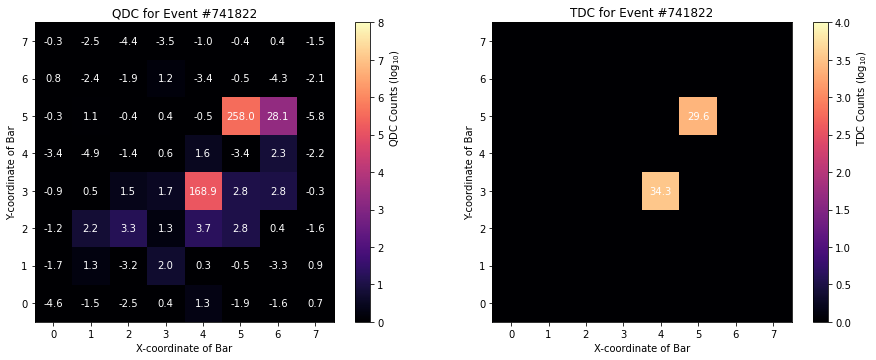

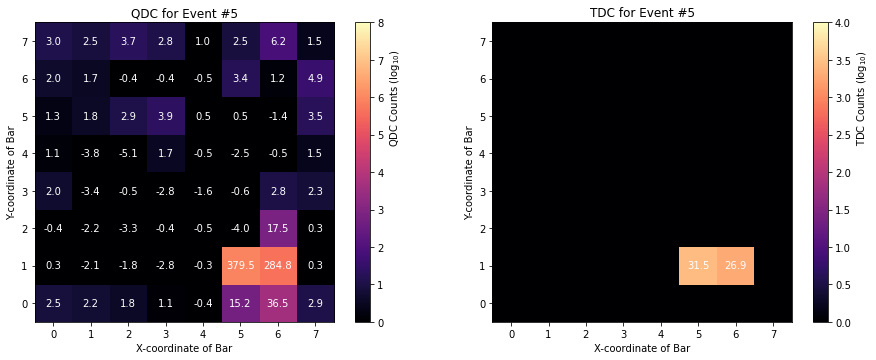

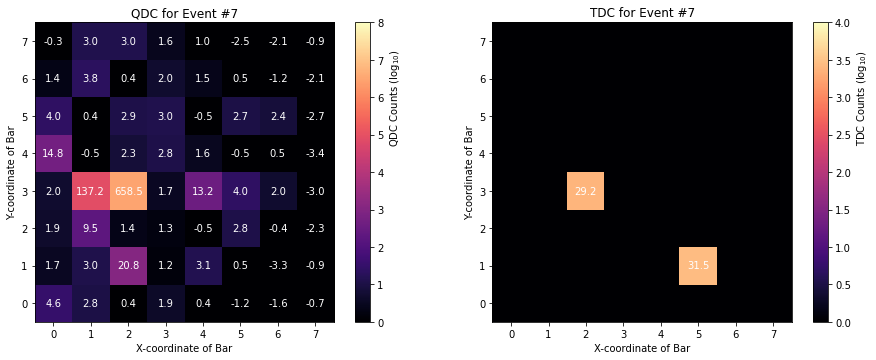

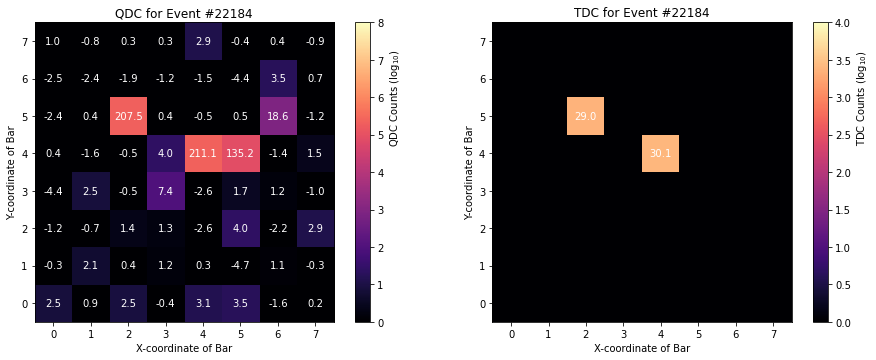

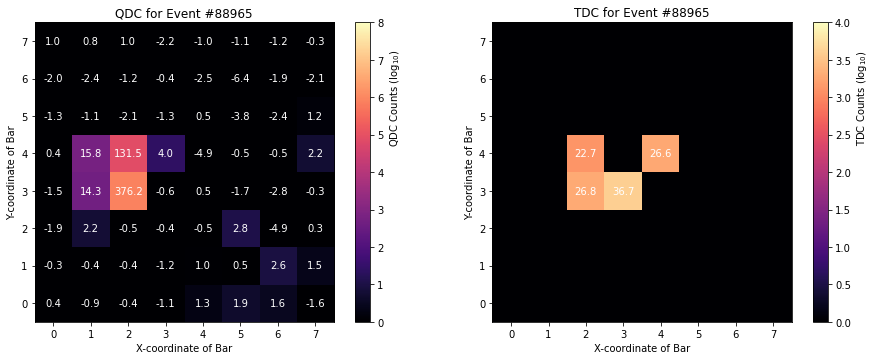

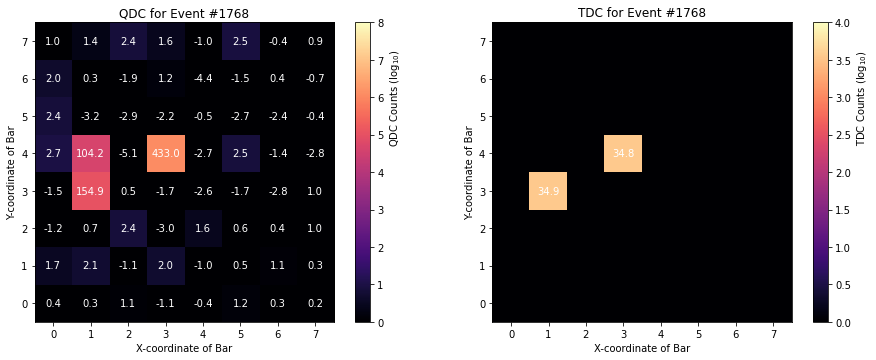

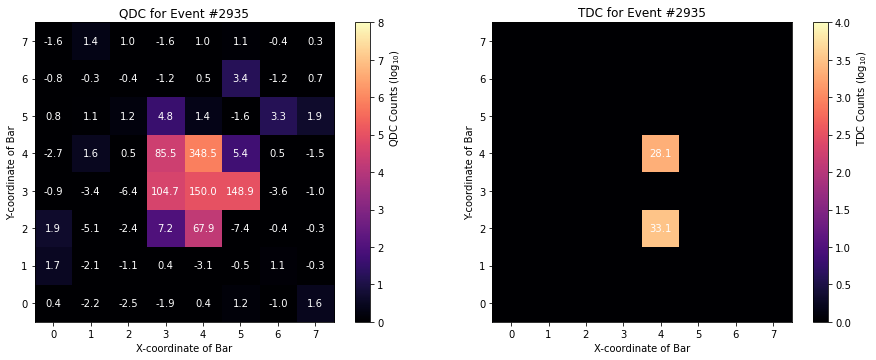

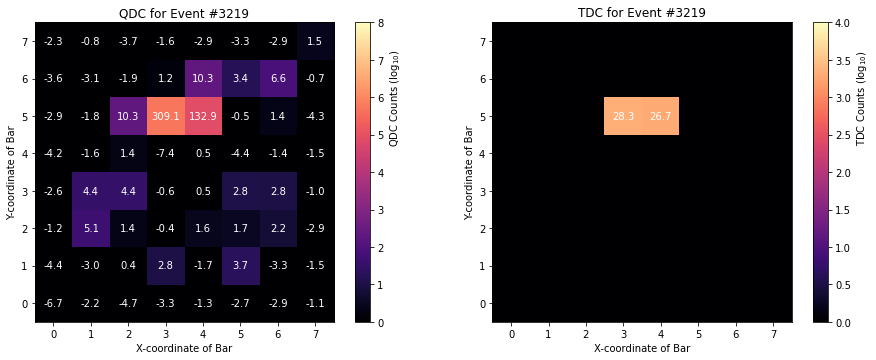

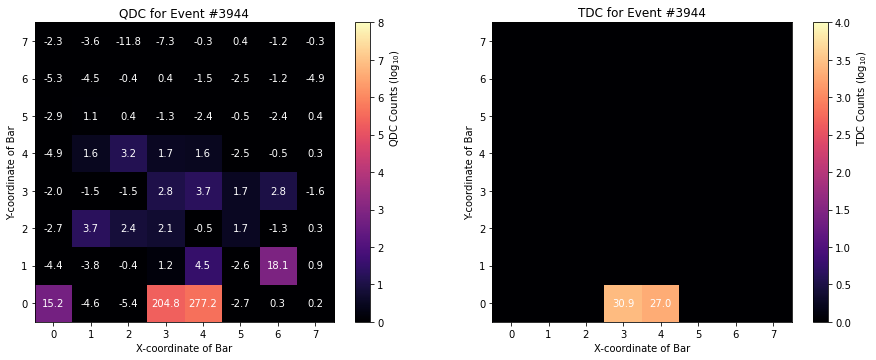

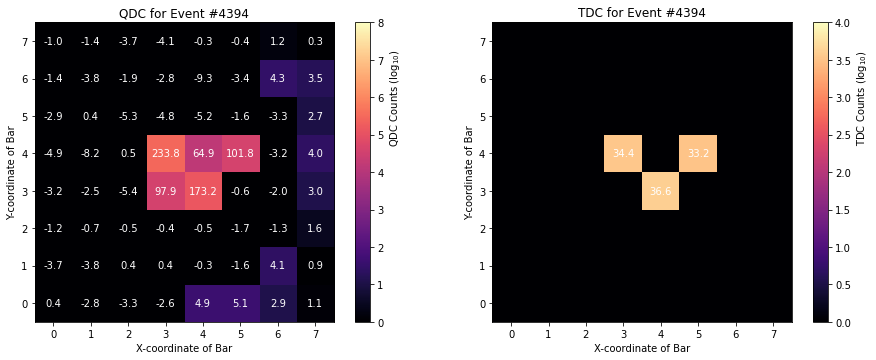

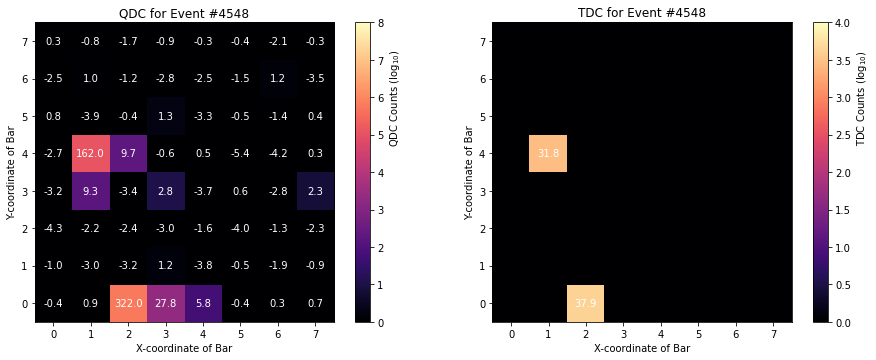

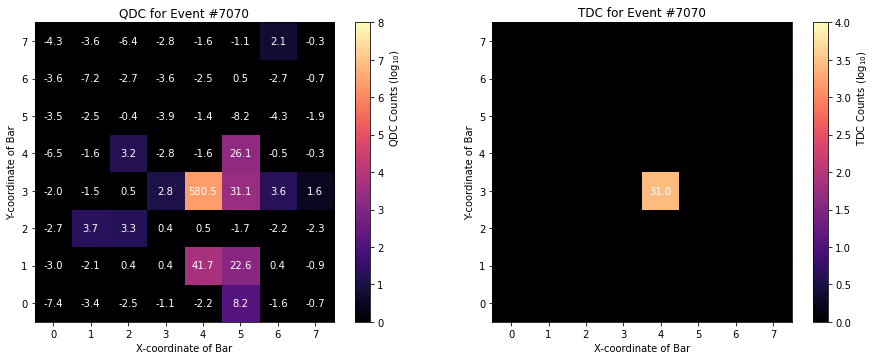

In [36]:
targets = [741822,5,7,22184,88965,1768,2935,3219,3944,4394,4548,7070]

for target in targets:
    event_num = np.where(raw_data[2]==target)[0][0]
    plotEvent(raw_data, event_num)

# for event_num in range(4000,5000,100):
#     plotEvent(raw_data, event_num)

---
# 3. Energy Sum Method 1 (`Esum1`): Nearest Neighbor (old)

## 3.x. Depracated Code

In [ ]:
##################################################################################
# Old method, pre `raw_data` formalization (changed on 6/28/22)
## I abandoned the scipy.convolve thing bc I don't want to add negative values


# def sum_nearestNeighbor(data):
#     '''
#     Takes an nx8x8 array of QDC values and applies the nearest neighbor summing method to all frames. Returns an n-dimensional array of energy sums for each event
#     '''
#     t0 = time.time()

#     E_sum = np.zeros((data.shape[0]), dtype=float)

#     for i_event in range(QDC.shape[0]):
        
#         thisFrame = QDC[i_event]
#         thisEsum, _ = sum_nearestNeighbor_frame(thisFrame)
#         E_sum[i_event] = thisEsum

#     t1 = time.time()
#     print(f"\"Nearest Neighbor\" energy sum took {t1-t0:.2f} seconds.")
    
#     return E_sum

# def sum_nearestNeighbor_frame(frame):
#     '''
#     Takes an 8x8 array of QDC values, finds the maximum value, and returns the sum of the max value + 8 surrounding values
#     '''
#     maxVal = np.amax(frame)
#     maxPos = np.where(maxVal == frame)
#     max_x = maxPos[0][0]
#     max_y = maxPos[1][0]

#     # Find sum of nearest neighbors with scipy
#     kernel = np.ones((3,3), dtype=int)
#     sumArr = convolve(frame, kernel, mode='constant')

#     thisEsum = sumArr[max_x][max_y]
    
#     return thisEsum, [max_x, max_y]

## 3.1. Helper Functions

In [5]:
def Esum1(raw_data, event_num, verbose=False):
    '''
    Takes an 8x8 array of QDC values, finds the maximum value, and returns the sum of the max value + 8 surrounding values
    '''
    
    # Initial values/params
    _, QDC, _ = raw_data[:]
    frame = QDC[event_num]
    
    maxVal = np.amax(frame)
    maxPos = np.where(maxVal == frame)
    max_x = maxPos[0][0]
    max_y = maxPos[1][0]
    
    # Sum surrounding 8 voxels
    
    Esum = 0
    threshold = 0 # QDC values above this threshold will be added to the total Esum
    
    maxVal2 = 0
    E_total = 0
    
    for x in range(8):
        for y in range(8):
            if frame[x][y] >= threshold:
                E_total += frame[x][y]
            
            if abs(x-max_x) <= 1 and abs(y-max_y) <= 1 and frame[x][y] >= threshold:
                Esum += frame[x][y]
                
                if (x,y)!=(max_x,max_y) and frame[x][y] > maxVal2:
                    maxVal2 = frame[x][y]
                
    # Verbose output
    if verbose:
        print(f'{Esum:.2f}            = Sum of nonzero QDC values in 8 bars surrounding max bar.')
        print(f'{maxVal:.2f} @ ({max_x},{max_y})    = Max QDC value and coordinate of bar.')
        print()
        print(f'{maxVal / Esum * 100:.2f}%            = Percent of energy sum deposited into central bar.')
        print(f'{(maxVal+maxVal2) / Esum * 100:.2f}%            = Percent of energy sum deposited into central bar + 2nd highest QDC bar.')
        print()
        print(f'{Esum / E_total * 100:.2f}%            = Percent of total energy captured by energy sum.')
        print()
        print(f'(Event Index {event_num})')

    
        # print(f'Sum of nonzero QDC values in 8 bars surrounding max bar          {Esum:.2f}')
        # print(f'Max QDC value and coordinate of bar                              {maxVal:.2f} @ ({max_x},{max_y})')
        # print(f'%Energy sum captured by central bar                              {maxVal / Esum * 100:.2f}%')
        # print(f'%Energy sum captured by central bar + 2nd highest QDC bar        {(maxVal+maxVal2) / Esum * 100:.2f}%.')
    
    return Esum #, [max_x, max_y]

## 3.2. Pre-calculate all Energy Sums

In [ ]:
# preallocate
all_Esums = np.zeros(np.shape(raw_data[1])[0], dtype=float)

# calc values
for event_num in range(np.shape(all_Esums)[0]):
    all_Esums[event_num] = Esum1(raw_data, event_num)

## 3.3. Calculate a Sample of Energy Sums and Show Plots

In [ ]:
# event_num=4
verbose = True

for event_num in range(0, np.shape(raw_data[1])[0], 100_000):
    plotEvent(raw_data, event_num)
    print()
    _ = Esum1(raw_data, event_num, verbose)
    print('\n\n\n')

---
# 4. Energy Sum Method 2 (`Esum2`): Sum Outliers with Noise Correction

## 4.1. Proof of Concept

To take a step back, our goal is to calculate the energy deposited by the scattering event into the calorimeter (via "particle showers"). Experimentally, we measure this with an 8x8 array of QDC sensors, each of which outputs a single scalar value for each event.

We may naively try to add up all QDC values, but this is inaccurate due to the presence of noise. This can be partially corrected for via a pedestal correction (see code/01/01_plotCaloHits). 

However there's still a bit of noise, so our goal is to isolate the voxels where most of the energy was deposited, both for the purpose of calculating the total energy of the event and understanding the shape of the shower for generative modelling.

One way to classify voxels as hit by the particle shower or not is by seeing which QDC values are outliers in the context of the entire dataset. This is done with simple IQR calculation.

In [ ]:
event_num = 58

# _, QDC, _ = raw_data[:]
# frame = QDC[event_num]

frame = raw_data[1][event_num]
# frame = np.where(raw_data[1][event_num] < 0, 0, raw_data[1][event_num]) # If you replace negative values with 0, you tend to capture more voxels. Not sure if this is a good thing.

q3, q1 = np.percentile(frame, [75, 25])
iqr = q3 - q1
outliers = np.where(frame > q3+1.5*iqr, True, False)


plotEvent(raw_data, event_num)

fig, ax = plt.subplots(figsize=(12,6))

ax.imshow(outliers.T, 'magma')
ax.invert_yaxis()

ax.set_title(f'QDC \"Hits\" for Event #{raw_data[2][event_num]}')
ax.set_xlabel('X-coordinate of Bar')
ax.set_ylabel('Y-coordinate of Bar')

print()


## 4.2. Helper Function

In [41]:
def Esum2(raw_data, event_num, verbose=False):
    '''
    Inputs: 
        `raw_data` 
            output of `load_TQDC`, containing [0]: TDC vals, [1]: QDC vals, and [2]: original event numbers before cut
    Output:
        Finds the total energy deposited by the scattering event by summing outliers, then subtracting the average non-outlier and subtracting it as noise
    '''
    
    _, QDC, ogEventNums = raw_data[:]
    
    ## 1. Find outliers and add to Esum
    frame = QDC[event_num]
    # frame = np.where(raw_data[1][event_num] < 0, 0, raw_data[1][event_num]) # If you replace negative values with 0, you tend to capture more voxels. Not sure if this is a good thing.
    
    q3, q1 = np.percentile(frame, [75, 25])
    iqr = q3 - q1
    outliers = np.where(frame > q3+1.5*iqr, True, False)
    
    Esum_noisy = np.sum(frame[outliers])
    
    ## 2. Find and subtract noise
    frame_zeroed = np.where(QDC[event_num] < 0, 0, QDC[event_num])
    avgNoise = np.average(frame_zeroed[np.invert(outliers)])
    
    numHits = np.sum(outliers)
    
    Esum = Esum_noisy - avgNoise * numHits

    # if Esum_noisy < 10:
    #     Esum_noisy, Esum = 0, 0
    
    
    # Verbose output
    if verbose:
        fig, ax = plt.subplots(figsize=(12,4.5))
        ax.imshow(outliers.T, 'magma')
        ax.invert_yaxis()
        ax.set_title(f'QDC \"Hits\" for Event #{ogEventNums[event_num]}')
        ax.set_xlabel('X-coordinate of Bar')
        ax.set_ylabel('Y-coordinate of Bar')
        plt.show()
        
        # print()
        # print(f'{Esum:.2f}            = Sum of QDC values for \"hit\" bars')
        # print()
        # print(f'{ (Esum-Esum_noisy) / Esum:.2f}%            = Percent of noise reduction.')
        # print(f'{Esum / (np.sum(frame_zeroed)) * 100:.2f}%            = Percent of total energy captured by energy sum.')
        # print()
        # print(f'(Event Index {event_num})')
    

    return Esum_noisy

## 4.3. Usage

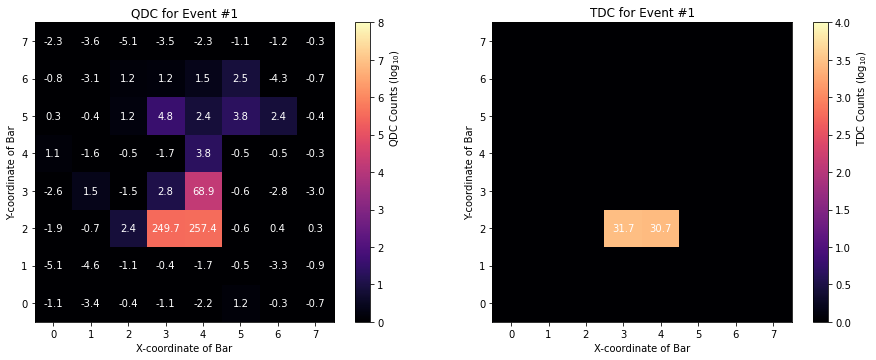

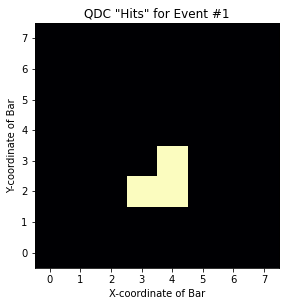


574.32            = Sum of QDC values for "hit" bars

-0.00%            = Percent of noise reduction.
94.03%            = Percent of total energy captured by energy sum.

(Event Index 0)






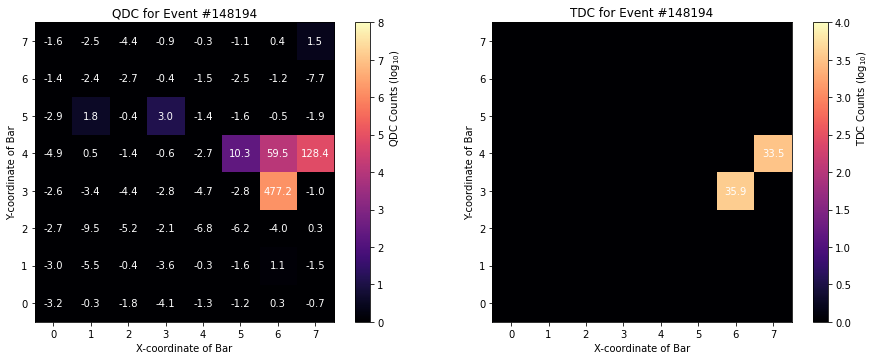

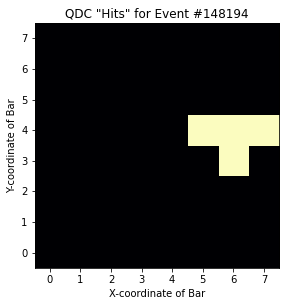


674.81            = Sum of QDC values for "hit" bars

-0.00%            = Percent of noise reduction.
98.59%            = Percent of total energy captured by energy sum.

(Event Index 100000)






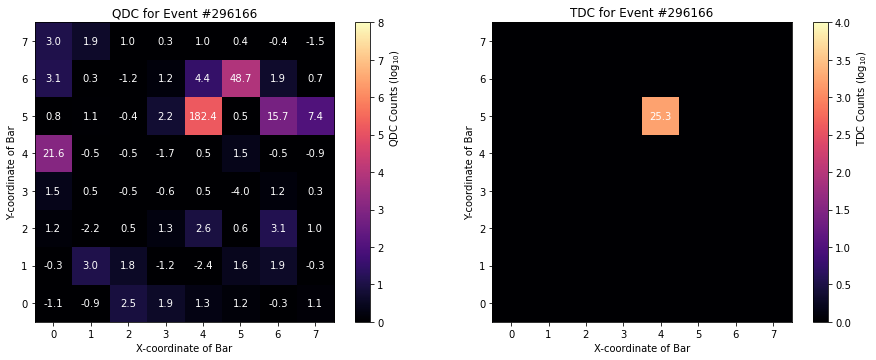

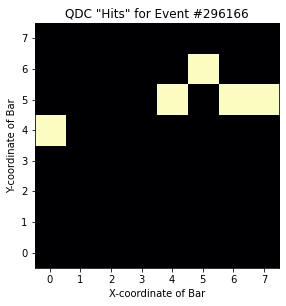


271.07            = Sum of QDC values for "hit" bars

-0.02%            = Percent of noise reduction.
81.63%            = Percent of total energy captured by energy sum.

(Event Index 200000)






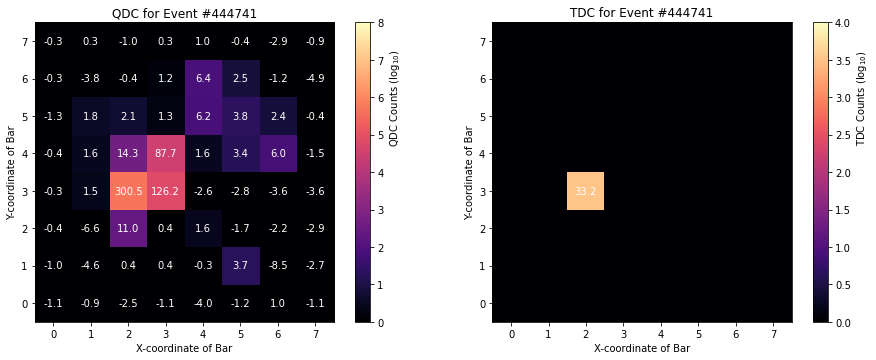

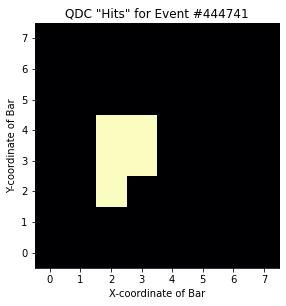


535.42            = Sum of QDC values for "hit" bars

-0.01%            = Percent of noise reduction.
90.68%            = Percent of total energy captured by energy sum.

(Event Index 300000)






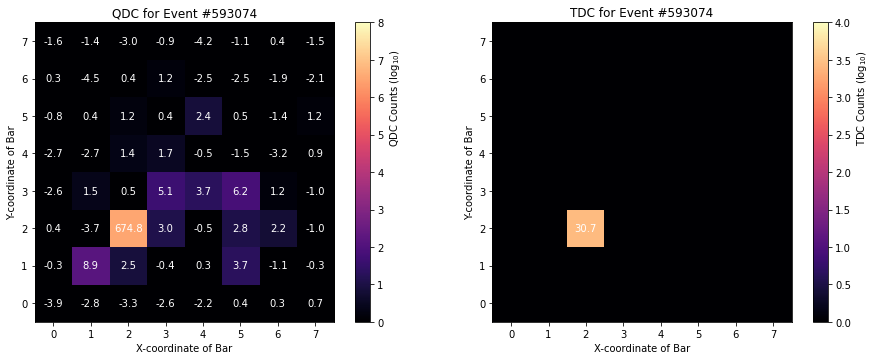

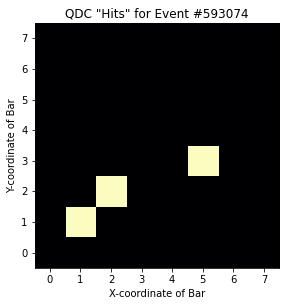


687.86            = Sum of QDC values for "hit" bars

-0.00%            = Percent of noise reduction.
94.16%            = Percent of total energy captured by energy sum.

(Event Index 400000)






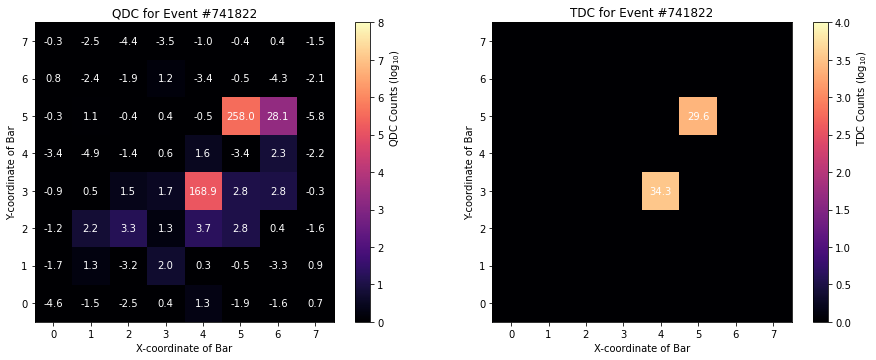

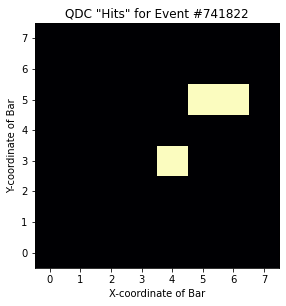


453.15            = Sum of QDC values for "hit" bars

-0.00%            = Percent of noise reduction.
91.84%            = Percent of total energy captured by energy sum.

(Event Index 500000)






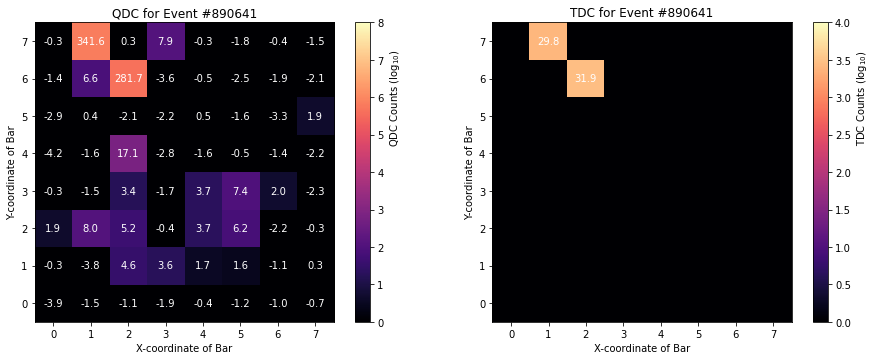

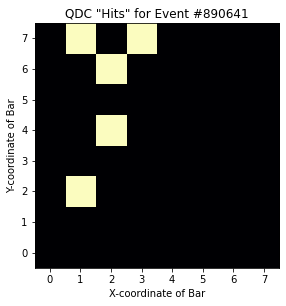


651.60            = Sum of QDC values for "hit" bars

-0.01%            = Percent of noise reduction.
91.61%            = Percent of total energy captured by energy sum.

(Event Index 600000)






In [39]:
verbose = True

for event_num in range(0, np.shape(raw_data[1])[0], 100_000):
    plotEvent(raw_data, event_num)
    print()
    _ = Esum2(raw_data, event_num, verbose)
    print('\n\n\n')

## 4.4. `Esum2` vs `Esum1`

In [ ]:
for event_num in range(0,100000,5000):# 0, np.shape(raw_data[1])[0], 100_000):
    plotEvent(raw_data, event_num)
    print()
    this_Esum1 = Esum1(raw_data, event_num)
    this_Esum2 = Esum2(raw_data, event_num)
    pDiff = (this_Esum1 - this_Esum2) / (this_Esum2+0.00001) * 100
    # if pDiff > max_pDiff:
    #     max_event = event_num
    print(f'Esum1   =  {this_Esum1:.2f}')
    print(f'Esum2   =  {this_Esum2:.2f}')
    print(f'% Diff  =  { pDiff :.2f}%')
    print('\n\n')

anlyzing individual events

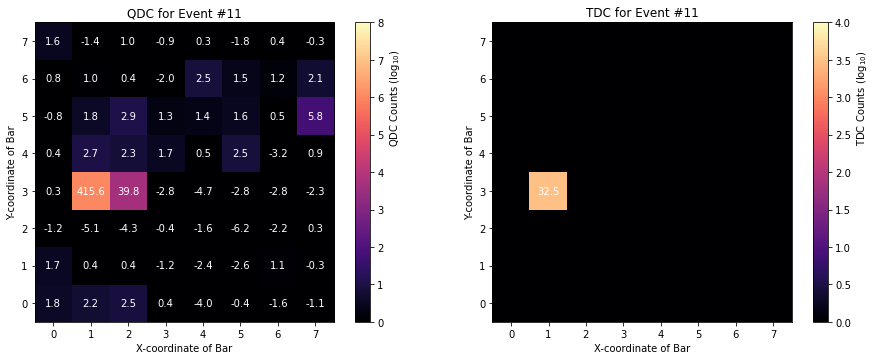


Esum1   =  461.12
Esum2   =  455.41
% Diff  =  1.25%



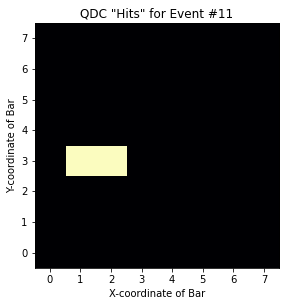

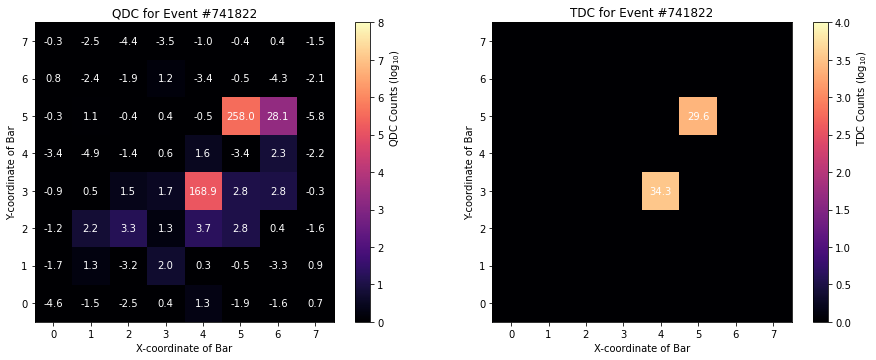


Esum1   =  290.04
Esum2   =  455.04
% Diff  =  -36.26%



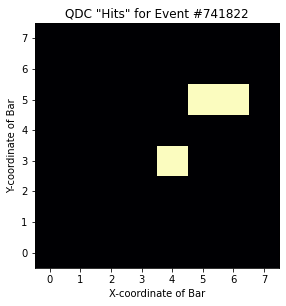

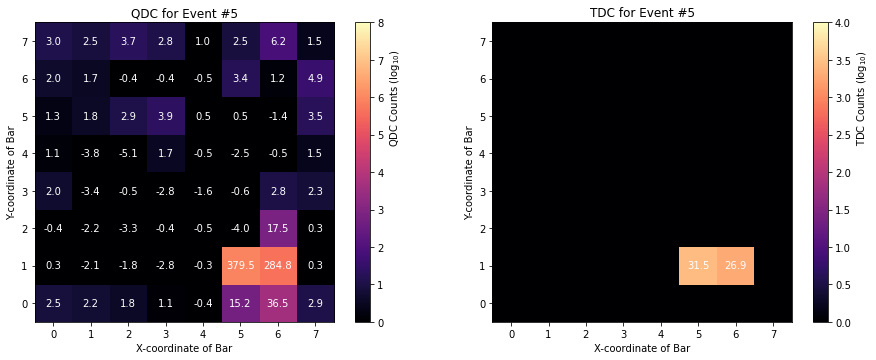


Esum1   =  733.40
Esum2   =  733.40
% Diff  =  0.00%



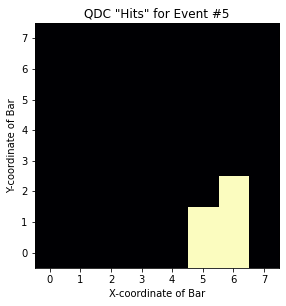

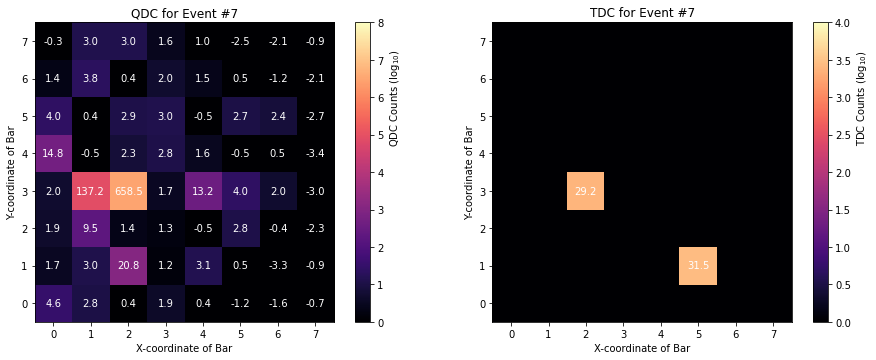


Esum1   =  814.79
Esum2   =  854.04
% Diff  =  -4.60%



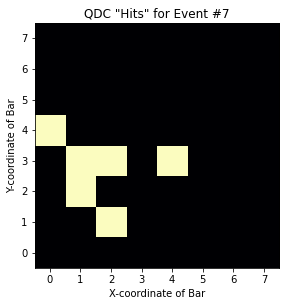

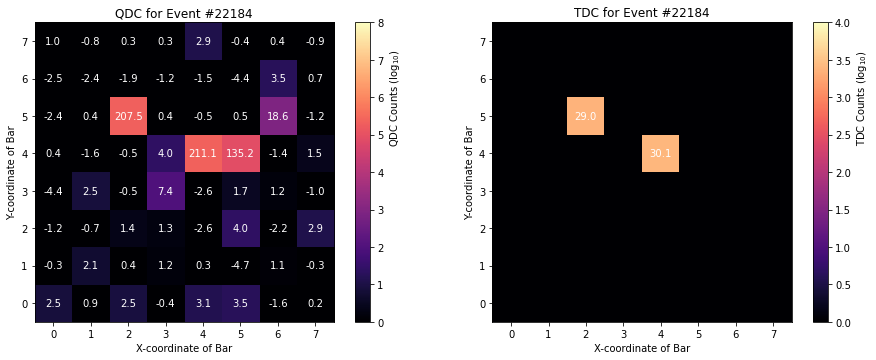


Esum1   =  360.34
Esum2   =  579.80
% Diff  =  -37.85%



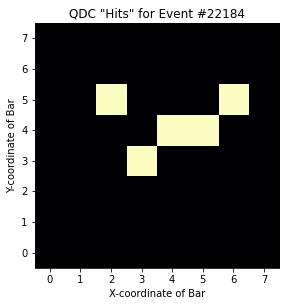

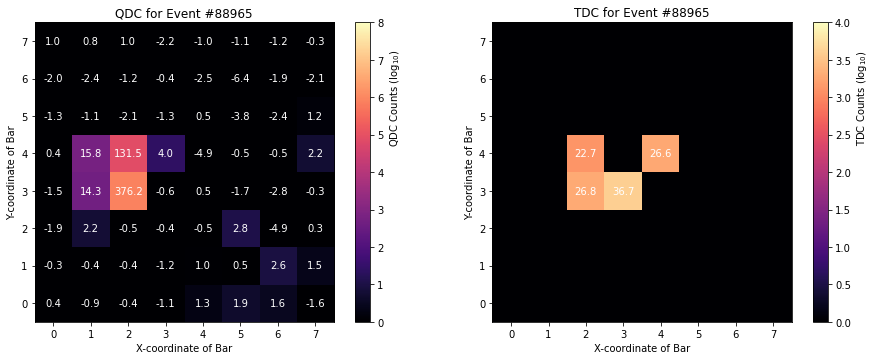


Esum1   =  544.01
Esum2   =  537.85
% Diff  =  1.14%



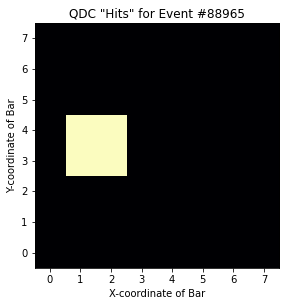

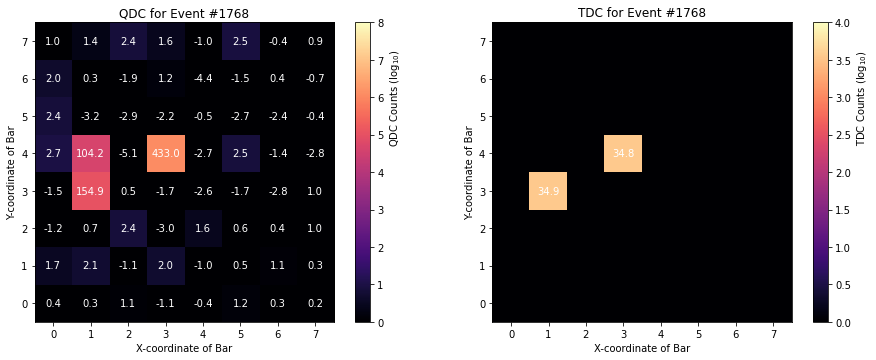


Esum1   =  433.51
Esum2   =  692.12
% Diff  =  -37.36%



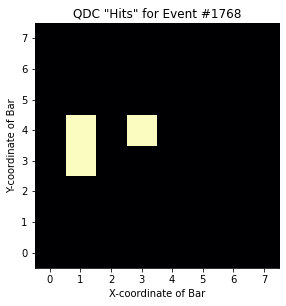

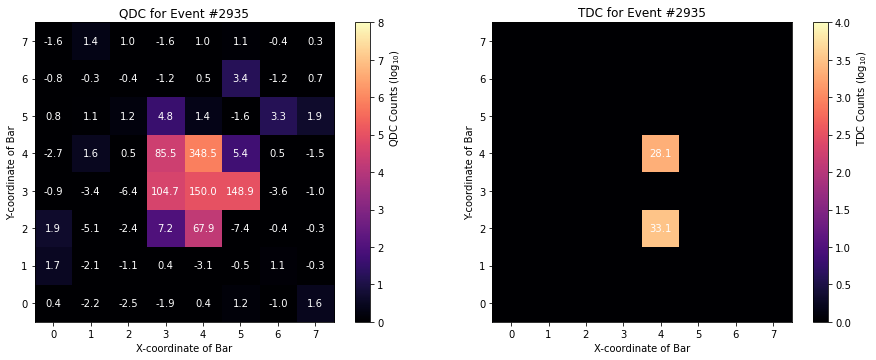


Esum1   =  849.23
Esum2   =  912.68
% Diff  =  -6.95%



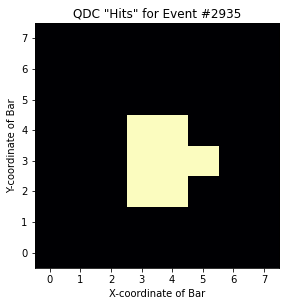

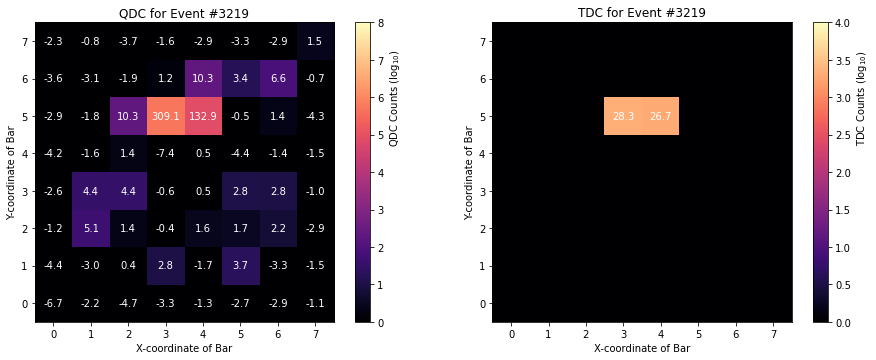


Esum1   =  465.72
Esum2   =  462.59
% Diff  =  0.68%



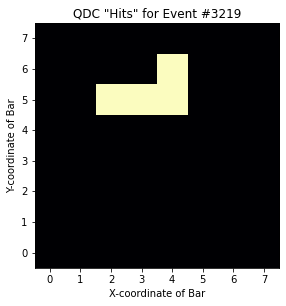

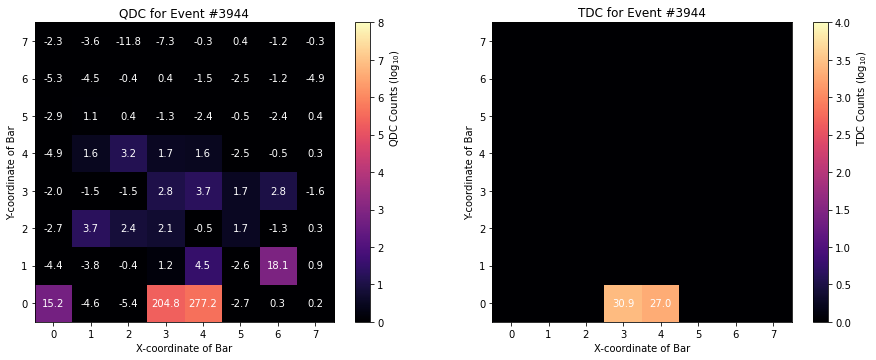


Esum1   =  487.66
Esum2   =  515.30
% Diff  =  -5.36%



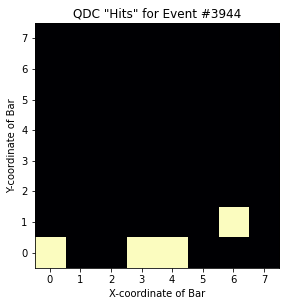

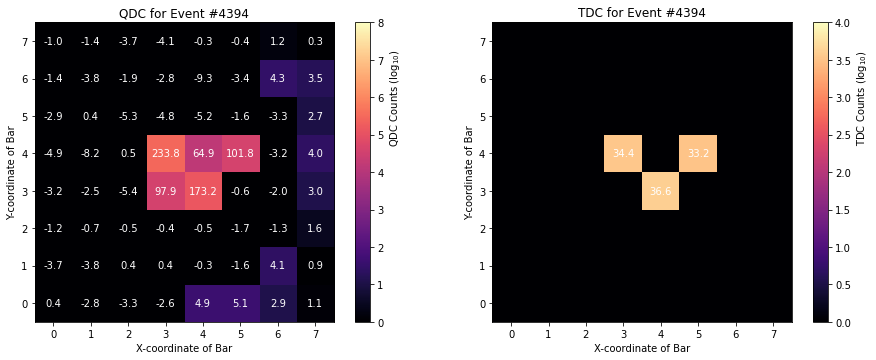


Esum1   =  570.23
Esum2   =  671.57
% Diff  =  -15.09%



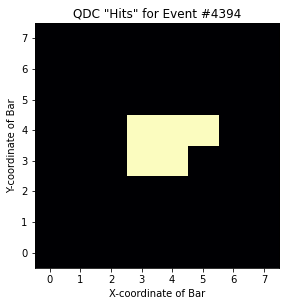

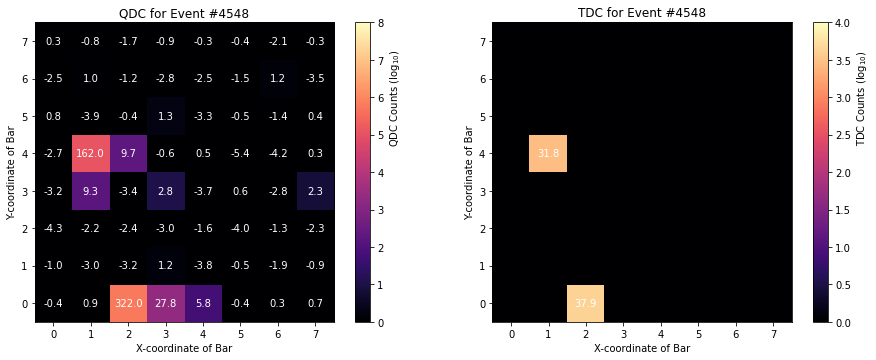


Esum1   =  351.95
Esum2   =  536.68
% Diff  =  -34.42%



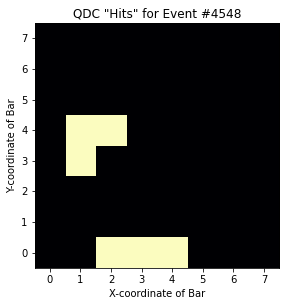

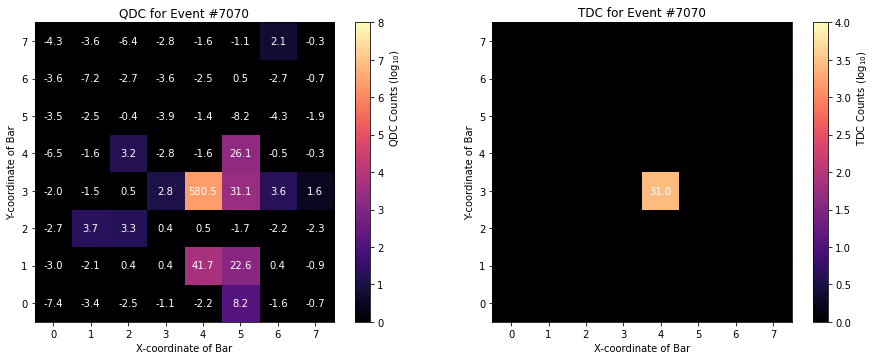


Esum1   =  641.50
Esum2   =  710.26
% Diff  =  -9.68%



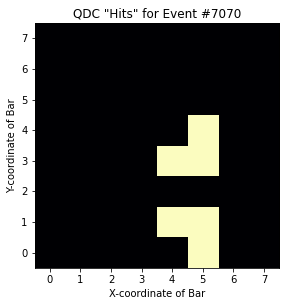

In [49]:
targets = [11,741822,5,7,22184,88965,1768,2935,3219,3944,4394,4548,7070]

for target in targets:
    event_num = np.where(raw_data[2]==target)[0][0]
    
    plotEvent(raw_data, event_num)
    print()
    this_Esum1 = Esum1(raw_data, event_num)
    this_Esum2 = Esum2(raw_data, event_num)
    pDiff = (this_Esum1 - this_Esum2) / (this_Esum2+0.00001) * 100
    # if pDiff > max_pDiff:
    #     max_event = event_num
    print(f'Esum1   =  {this_Esum1:.2f}')
    print(f'Esum2   =  {this_Esum2:.2f}')
    print(f'% Diff  =  { pDiff :.2f}%')
    print()
    _ = Esum2(raw_data, event_num, verbose)
    print('\n\n')
    

---
# Scrapwork

In [82]:
total_num_events = np.shape(raw_data[0])[0]
num_double_events = 0

for event_num in range(total_num_events):
    frame = raw_data[0][event_num]
    
    maxVal = np.amax(frame)
    
    minVal = 0
    for x in range(8):
        for y in range(8):
            if frame[x][y] > minVal and frame[x][y] != maxVal:
                minVal = frame[x][y]
                
    if maxVal - minVal > 1.5 and minVal > 1:
        num_double_events += 1    

In [83]:
print(num_double_events)
print(total_num_events)
print(num_double_events / total_num_events)

122966
674056
0.18242697936076527


In [ ]:
sumFrame_nearestNeighbor(raw_data, 7)

---
# Bugs/Notes

- [ ] `Esum2`'s outlier identifier accidentally classifies events where there appears to be no qdc/tdc event -- see event_num 5
    - Fix this by brute forcing an if statement like "if max qdc lower than 5 (or perhaps 10) then call it a no hit event
- [x] not sure if E-sum method works properly, check a few by hand
- [x] somewhere along the way, my x and y coords got mixed up -- 2dhistogram and coordinates from sum function do not match
- [x] stylistically, its weird that plotEvent_QDC & plotEvent_TDC take event indices, but naivesumframe takes an entire frame... keep in mind that jupyter keeps all variables global; i'd want strict inputs/outputs if i ever made this into a .py script, but will i ever do that realistically? and if i do, it wouldn't be too hard to correct...

Useful comment for docstrings: 

```
Warning: This function uses variables that are not explicitly passed. Variables must be declared earlier on and with the same exact name as they appear in the function.
    - `ogEventNums`: original event numbers before cuts were applied, gotten from `load_TQDC`.
```